In [36]:
import pandas as pd
import numpy as np
import gc
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from scipy import sparse
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc

%matplotlib inline

In [3]:
dftrain = pd.read_csv('datasources/jigsaw1/train.csv').fillna(' ')
dftest = pd.read_csv('datasources/jigsaw1/test.csv').fillna(' ')

traincomments = dftrain['comment_text']
testcomments = dftest['comment_text']
wikicomments = pd.concat([traincomments, testcomments])

wikicomments = wikicomments
print('train : {}'.format(traincomments.shape))
print('test  : {}'.format(testcomments.shape))
print('train + test : {}'.format(wikicomments.shape))

train : (159571,)
test  : (153164,)
train + test : (312735,)


In [4]:
dftest['comment_text'].sample(10)

163       June 2007 (UTC) \n :It being a first isn't ver...
68200     No, she Sucks. She makes christians look bad a...
22457     Having dealt with a couple of other disruptive...
71888     " \n\n :::: The situation on Reach was perilou...
42826     == Acetyl L-Carnitine== \n I believe it should...
88328     ::There are images of Pauling's Pierre Fermat ...
115181    . Further comments about this particular matte...
24157     ::I did some copyediting.  The article is quit...
13288     :We got snow here in Boston, too. ( Flying hom...
119386    == Tagging living people as Jews == \n\n There...
Name: comment_text, dtype: object

### Analyse par  tfidf: TfidfVectorizer =  CountVectorizer + TfidfTransformer.

In [5]:
vect_word = TfidfVectorizer(max_features=20000, lowercase=True, analyzer='word',
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)

In [6]:
# Word ngram vector
train_vect = vect_word.fit_transform(dftrain['comment_text'])
test_vect = vect_word.transform(dftest['comment_text'])

In [7]:
train_vect.shape

(159571, 20000)

In [8]:
print(len(vect_word.get_feature_names()))

20000


In [23]:
vect_char = TfidfVectorizer(max_features=40000, lowercase=True, analyzer='char',
                        stop_words= 'english',ngram_range=(3,6),dtype=np.float32)

In [24]:
# Character n gram vector
tr_vect_char = vect_char.fit_transform(dftrain['comment_text'])
ts_vect_char = vect_char.transform(dftest['comment_text'])

In [11]:
vect_char.get_feature_names()

['\n(u',
 '\n,\n',
 '\n,\n,',
 '\n,\n,\n',
 '\n,\n,\n,',
 '\ni ',
 '\ni w',
 '\nth',
 '\nthe',
 '\nthe ',
 ' ""',
 ' "" ',
 ' ""a',
 ' ""ai',
 ' ""aid',
 ' ""al',
 ' ""b',
 ' ""c',
 ' ""ca',
 ' ""can',
 ' ""d',
 ' ""di',
 ' ""dis',
 ' ""g',
 ' ""ge',
 ' ""get',
 ' ""go',
 ' ""h',
 ' ""he',
 ' ""he\'',
 ' ""ho',
 ' ""hot',
 ' ""i',
 ' ""is',
 ' ""it',
 ' ""it ',
 ' ""m',
 ' ""o',
 ' ""p',
 ' ""r',
 ' ""ro',
 ' ""s',
 ' ""sa',
 ' ""sat',
 ' ""t',
 ' ""th',
 ' ""the',
 ' ""w',
 ' ""wh',
 ' ""whe',
 ' ""wi',
 ' ""win',
 ' (1',
 ' (1)',
 ' (1) ',
 ' (10',
 ' (109',
 ' (1091',
 ' (2',
 ' (2)',
 ' (2) ',
 ' (b',
 ' (g',
 ' (go',
 ' (gov',
 ' (gove',
 ' (i',
 ' (i ',
 ' (k',
 ' (n',
 ' (no',
 ' (o',
 ' (or',
 ' (or ',
 ' (p',
 ' (s',
 ' (sa',
 ' (t',
 ' (ta',
 ' (tal',
 ' (talk',
 ' (th',
 ' (u',
 ' (ut',
 ' (utc',
 ' (utc)',
 ' (w',
 ' (wh',
 ' , ',
 ' , ,',
 ' , , ',
 ' , , ,',
 ' - ',
 ' - a',
 ' - t',
 ' - th',
 ' - the',
 ' - w',
 ' - wh',
 ' . ',
 ' . .',
 ' . . ',
 ' 10',
 ' 10.',
 ' 10

In [26]:
train_vect.shape, tr_vect_char.shape

((159571, 20000), (159571, 40000))

In [27]:
X = sparse.hstack([train_vect, tr_vect_char])

In [28]:
x_test = sparse.hstack([test_vect, ts_vect_char])

In [31]:
target_col = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
y = dftrain[target_col]

In [32]:
prd = np.zeros((x_test.shape[0],y.shape[1]))
cv_score =[]
for i,col in enumerate(target_col):
    lr = LogisticRegression(C=2,random_state = i,class_weight = 'balanced')
    print('Building {} model for column:{''}'.format(i,col)) 
    lr.fit(X,y[col])
    #cv_score.append(lr.score)
    prd[:,i] = lr.predict_proba(x_test)[:,1]

Building 0 model for column:toxic


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Building 1 model for column:severe_toxic
Building 2 model for column:obscene
Building 3 model for column:threat
Building 4 model for column:insult
Building 5 model for column:identity_hate


In [41]:
prd

array([[9.99999871e-01, 9.01561012e-01, 9.99999860e-01, 4.91429760e-01,
        9.99661505e-01, 9.85758776e-01],
       [5.68347385e-03, 8.61755859e-04, 6.47509850e-04, 2.51010694e-04,
        7.05927547e-03, 5.42695036e-03],
       [2.92432561e-02, 3.38268871e-03, 7.40298563e-02, 2.03714418e-04,
        1.27111023e-02, 5.29236089e-03],
       ...,
       [2.11226712e-03, 1.04614501e-03, 2.82520281e-02, 3.68447479e-04,
        2.57385147e-03, 7.28203993e-04],
       [2.08835618e-02, 1.89189908e-03, 1.89505987e-02, 2.28141555e-03,
        3.35992502e-03, 5.39341085e-02],
       [9.99859956e-01, 2.06473299e-04, 9.96420991e-01, 3.22918124e-02,
        9.21669073e-01, 3.85646707e-03]])

In [34]:
del train_vect, test_vect, tr_vect_char, ts_vect_char
gc.collect()

53

In [44]:
for col in target_col:
    print(100 * '=')
    print("Column:",col)
    pred =  lr.predict(X)
    print('\nConfusion matrix\n',confusion_matrix(y[col],pred))
    print(classification_report(y[col],pred))
    

Column: toxic

Confusion matrix
 [[143846    431]
 [ 12581   2713]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    144277
           1       0.86      0.18      0.29     15294

   micro avg       0.92      0.92      0.92    159571
   macro avg       0.89      0.59      0.63    159571
weighted avg       0.91      0.92      0.89    159571

Column: severe_toxic

Confusion matrix
 [[155497   2479]
 [   930    665]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    157976
           1       0.21      0.42      0.28      1595

   micro avg       0.98      0.98      0.98    159571
   macro avg       0.60      0.70      0.63    159571
weighted avg       0.99      0.98      0.98    159571

Column: obscene

Confusion matrix
 [[149998   1124]
 [  6429   2020]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98    151122
           1       0.64 

Column: toxic
Column: severe_toxic
Column: obscene
Column: threat
Column: insult
Column: identity_hate


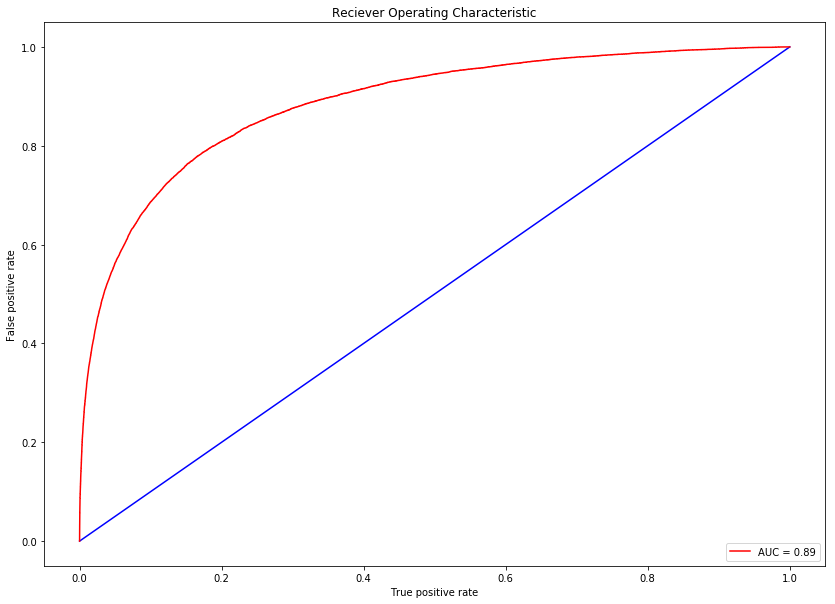

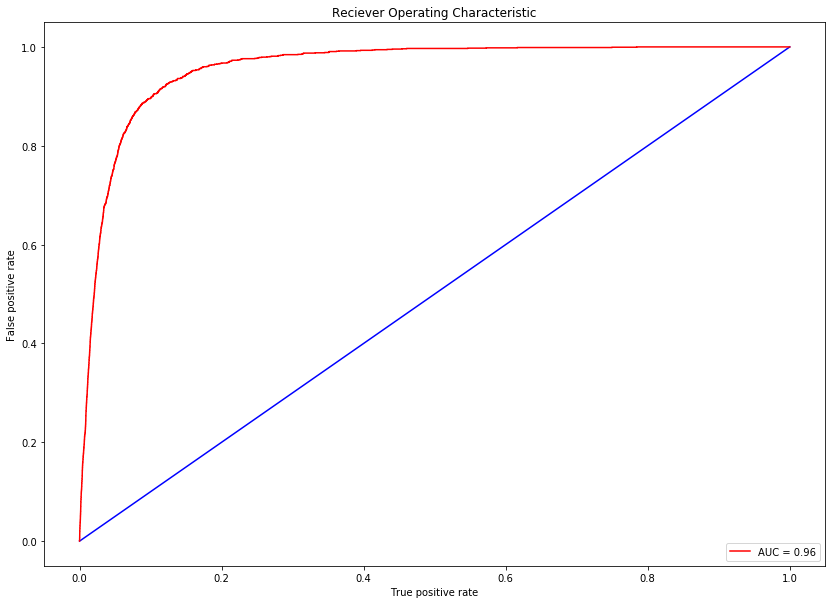

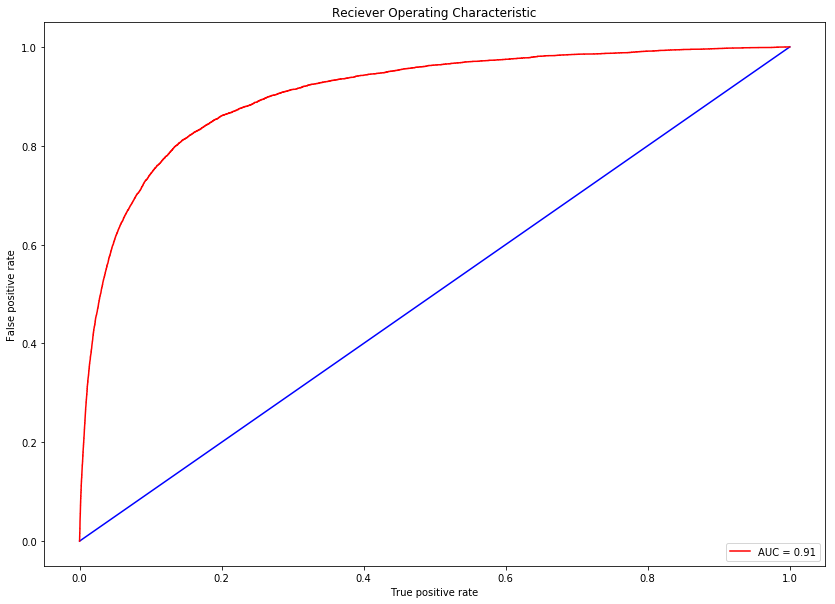

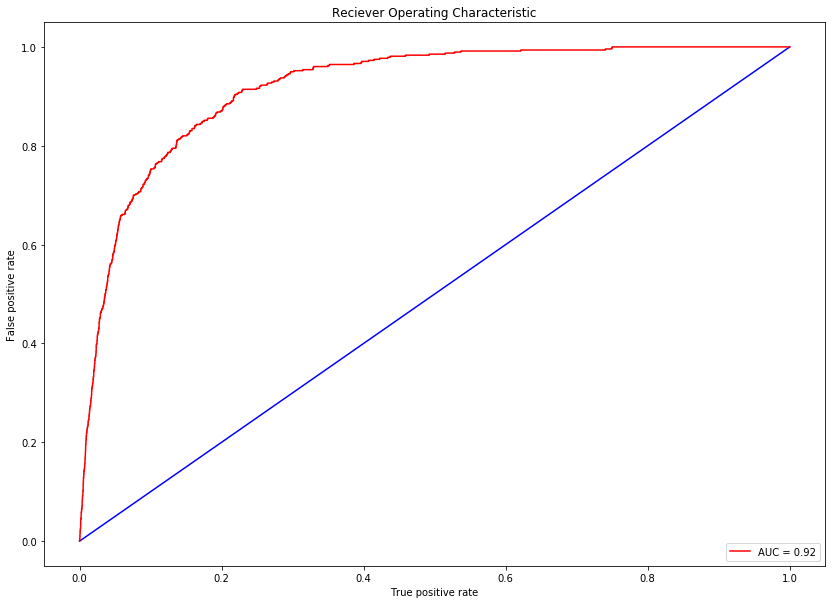

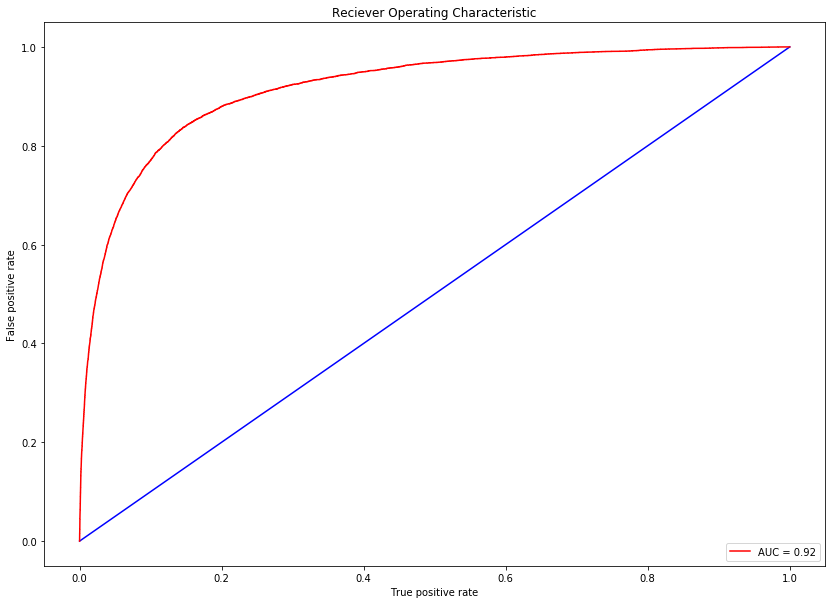

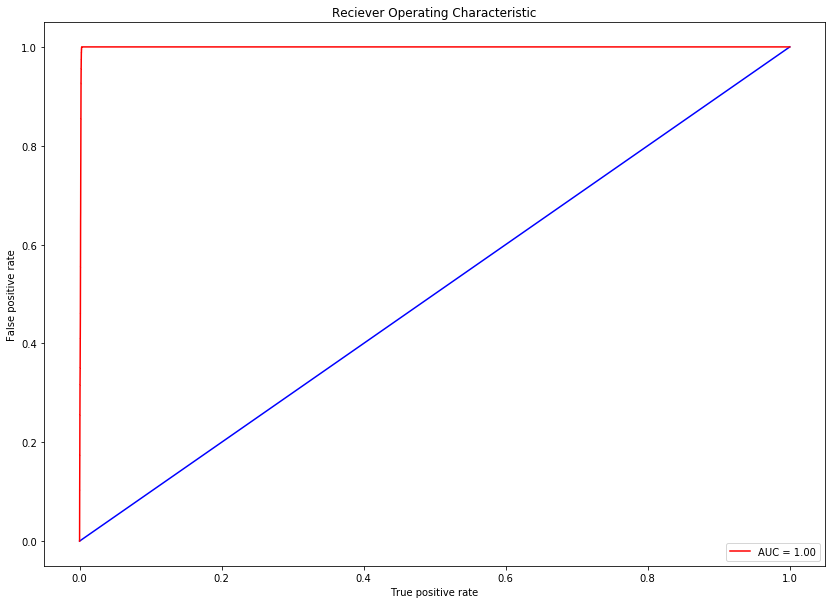

In [45]:
for col in target_col:    
    print(100 * '=')
    print("Column:",col)
    pred_pro = lr.predict_proba(X)[:,1]
    frp,trp,thres = roc_curve(y[col],pred_pro)
    auc_val =auc(frp,trp)
    plt.figure(figsize=(14,10))
    plt.plot([0,1],[0,1],color='b')
    plt.plot(frp,trp,color='r',label= 'AUC = %.2f'%auc_val)
    plt.legend(loc='lower right')
    plt.xlabel('True positive rate')
    plt.ylabel('False positive rate')
    plt.title('Reciever Operating Characteristic')

In [43]:
print(100 * '=')

In [48]:
prd_1 = pd.DataFrame(prd,columns=y.columns)
submit = pd.concat([dftest['id'],prd_1],axis=1)
#submit.to_csv('toxic_lr.csv.gz',compression='gzip',index=False)
#submit.to_csv('toxic_lr.csv',index=False)
submit.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,1.000000,0.901561,1.000000,0.491430,0.999662,0.985759
1,0000247867823ef7,0.005683,0.000862,0.000648,0.000251,0.007059,0.005427
2,00013b17ad220c46,0.029243,0.003383,0.074030,0.000204,0.012711,0.005292
3,00017563c3f7919a,0.005023,0.008118,0.002027,0.000853,0.002857,0.000310
4,00017695ad8997eb,0.021478,0.002895,0.008750,0.001202,0.012713,0.000620
5,0001ea8717f6de06,0.006754,0.000848,0.003964,0.002407,0.031440,0.002835
6,00024115d4cbde0f,0.005663,0.000691,0.008709,0.000155,0.006647,0.003563
7,000247e83dcc1211,0.946600,0.002033,0.140148,0.003684,0.169248,0.000614
8,00025358d4737918,0.002877,0.000585,0.011823,0.000669,0.003586,0.000472
9,00026d1092fe71cc,0.002636,0.001834,0.002655,0.000465,0.011597,0.001459
